# Neural Network Second Attempt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('coaster_db_clean.csv')
df.head()

2025-10-19 13:33:15.018438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Unnamed: 0,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,year_introduced,...,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft
0,0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,Unknown,LaMarcus Adna Thompson,1884,...,0,2.9,600.0,48.0,8540000.0,9.1,30.0,60.0,1600,43.0
1,1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,Unknown,Unknown,a single car. Riders are arranged 1 across in ...,Lina Beecher,1895,...,1,12.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
2,3,Loop the Loop (Coney Island),Other,Removed,Edwin Prescott,Unknown,Unknown,a single car. Riders are arranged 2 across in ...,Edward A. Green,1901,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
3,4,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,Unknown,Unknown,Unknown,Edward A. Green,1901,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
4,5,Cannon Coaster,Coney Island,Removed,George Francis Meyer,Unknown,Unknown,Unknown,Unknown,1902,...,0,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1028 non-null   int64  
 1   coaster_name              1028 non-null   object 
 2   Location                  1028 non-null   object 
 3   Status                    1028 non-null   object 
 4   Manufacturer              1028 non-null   object 
 5   Model                     1028 non-null   object 
 6   Lift/launch system        1028 non-null   object 
 7   Trains                    1028 non-null   object 
 8   Designer                  1028 non-null   object 
 9   year_introduced           1028 non-null   int64  
 10  latitude                  1028 non-null   float64
 11  longitude                 1028 non-null   float64
 12  track_type                1028 non-null   object 
 13  opening_date_clean        1028 non-null   object 
 14  speed_mp

In [3]:
df = df.drop(df.columns[0], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              1028 non-null   object 
 1   Location                  1028 non-null   object 
 2   Status                    1028 non-null   object 
 3   Manufacturer              1028 non-null   object 
 4   Model                     1028 non-null   object 
 5   Lift/launch system        1028 non-null   object 
 6   Trains                    1028 non-null   object 
 7   Designer                  1028 non-null   object 
 8   year_introduced           1028 non-null   int64  
 9   latitude                  1028 non-null   float64
 10  longitude                 1028 non-null   float64
 11  track_type                1028 non-null   object 
 12  opening_date_clean        1028 non-null   object 
 13  speed_mph                 1028 non-null   float64
 14  height_f

In [4]:
# Features and target
X = df.drop(columns=['track_type'])
y = df['track_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# numeric and categorical feature lists
numeric_features = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [5]:
model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
X_train_prep = X_train_prep.toarray()
X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5288 - loss: 1.0075 - val_accuracy: 0.7879 - val_loss: 0.6383
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7920 - loss: 0.5637 - val_accuracy: 0.7879 - val_loss: 0.4483
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8368 - loss: 0.3765 - val_accuracy: 0.8970 - val_loss: 0.3497
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9500 - loss: 0.2341 - val_accuracy: 0.9091 - val_loss: 0.2955
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9574 - loss: 0.1650 - val_accuracy: 0.9212 - val_loss: 0.2611
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9682 - loss: 0.1006 - val_accuracy: 0.9212 - val_loss: 0.2615
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9726 - loss: 0.0683 - val_accuracy: 0.9273 - val_loss: 0.2571
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9824 - loss: 0.0440 - val_accuracy: 0.9273 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test Accuracy: 0.9466

Classification Report:
              precision    recall  f1-score   support

       Other       0.62      0.71      0.67         7
       Steel       0.98      0.96      0.97       163
        Wood       0.89      0.92      0.90        36

    accuracy                           0.95       206
   macro avg       0.83      0.86      0.85       206
weighted avg       0.95      0.95      0.95       206



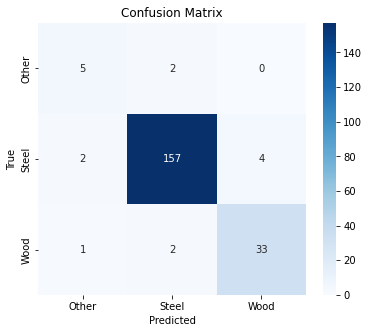

In [6]:
# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

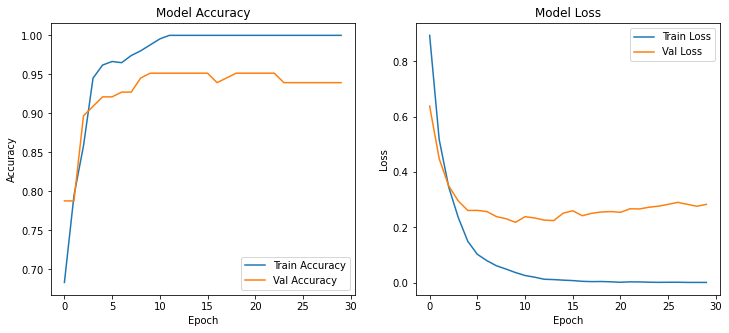

In [7]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Reducing Steel

So if we look at our value counts

In [8]:
df['track_type'].value_counts(normalize=True)

Steel    0.791829
Wood     0.172179
Other    0.035992
Name: track_type, dtype: float64

It's pretty obvious there's way more steel track than wood or other. The exact values of that are

In [9]:
df = pd.read_csv('coaster_db_clean.csv')
df = df.drop(df.columns[0], axis=1)
print(str(len(df[df['track_type'] == 'Steel'])) + " steel coasters")

814 steel coasters


In [10]:
print(str(len(df[df['track_type'] == 'Wood'])) + " wood coasters")

177 wood coasters


In [11]:
print("and " + str(len(df[df['track_type'] == 'Other'])) + " coasters classified as other")

and 37 coasters classified as other


In [12]:
num_rows_to_remove = 600

# 1. Identify the target rows
target_df = df[df['track_type'] == 'Steel']

# 2. Randomly sample from target rows
# Ensure that num_rows_to_remove does not exceed the number of available target rows
if num_rows_to_remove > len(target_df):
    print(f"Warning: Cannot remove {num_rows_to_remove} rows. Only {len(target_df)} rows with '{target_value}' in '{column_name}' exist.")
    num_rows_to_remove = len(target_df) # Adjust to remove all available rows

rows_to_drop_indices = target_df.sample(n=num_rows_to_remove, random_state=42).index # random_state for reproducibility

# 3. Drop the sampled rows
df = df.drop(rows_to_drop_indices)

print("\nDataFrame after removing random rows:")
df.head()


DataFrame after removing random rows:


,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,year_introduced,latitude,...,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft
0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,Unknown,LaMarcus Adna Thompson,1884,40.5740,...,0,2.9,600.0,48.0,8540000.0,9.1,30.0,60.0,1600,43.0
1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,Unknown,Unknown,a single car. Riders are arranged 1 across in ...,Lina Beecher,1895,40.5780,...,1,12.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
3,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,Unknown,Unknown,Unknown,Edward A. Green,1901,39.3538,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
4,Cannon Coaster,Coney Island,Removed,George Francis Meyer,Unknown,Unknown,Unknown,Unknown,1902,40.5750,...,0,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
5,Leap-The-Dips,Lakemont Park,Operating,Federal Construction Company,Unknown,Unknown,Unknown,Edward Joy Morris,1902,40.2864,...,0,4.0,1452.0,48.0,8540000.0,9.1,25.0,60.0,1080,9.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 1025
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              428 non-null    object 
 1   Location                  428 non-null    object 
 2   Status                    428 non-null    object 
 3   Manufacturer              428 non-null    object 
 4   Model                     428 non-null    object 
 5   Lift/launch system        428 non-null    object 
 6   Trains                    428 non-null    object 
 7   Designer                  428 non-null    object 
 8   year_introduced           428 non-null    int64  
 9   latitude                  428 non-null    float64
 10  longitude                 428 non-null    float64
 11  track_type                428 non-null    object 
 12  opening_date_clean        428 non-null    object 
 13  speed_mph                 428 non-null    float64
 14  height_ft

In [14]:
df['track_type'].value_counts(normalize=True)

Steel    0.500000
Wood     0.413551
Other    0.086449
Name: track_type, dtype: float64

So let's see how our model does now

In [15]:
# Features and target
X = df.drop(columns=['track_type'])
y = df['track_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# numeric and categorical feature lists
numeric_features = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

In [16]:
model = keras.Sequential([
    keras.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# convert sparse matrices to dense numpy arrays
X_train_prep = X_train_prep.toarray()
X_test_prep = X_test_prep.toarray()

history = model.fit(
    X_train_prep, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4357 - loss: 1.0606 - val_accuracy: 0.6377 - val_loss: 0.9302
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6817 - loss: 0.8807 - val_accuracy: 0.7681 - val_loss: 0.8000
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7372 - loss: 0.7824 - val_accuracy: 0.8551 - val_loss: 0.6723
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8549 - loss: 0.6151 - val_accuracy: 0.8696 - val_loss: 0.5538
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8485 - loss: 0.5078 - val_accuracy: 0.8841 - val_loss: 0.4481
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8650 - loss: 0.3881 - val_accuracy: 0.8841 - val_loss: 0.3673
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8995 - loss: 0.3132 - val_accuracy: 0.9130 - val_loss: 0.3158
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9287 - loss: 0.2199 - val_accuracy: 0.9275 - val_loss: 0.2827
Epoch 9

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test Accuracy: 0.8605

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      0.43      0.60         7
       Steel       0.80      0.95      0.87        43
        Wood       0.94      0.83      0.88        36

    accuracy                           0.86        86
   macro avg       0.91      0.74      0.78        86
weighted avg       0.88      0.86      0.85        86



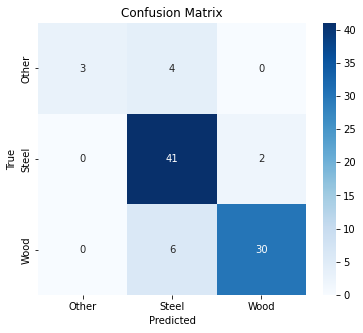

In [17]:
# Predictions
y_pred_probs = model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)   # take highest prob as class

# If y_test_enc is one-hot, convert back to integer labels
if y_test_enc.ndim > 1 and y_test_enc.shape[1] > 1:
    y_true = np.argmax(y_test_enc, axis=1)
else:
    y_true = y_test_enc  

# Accuracy
test_loss, test_acc = model.evaluate(X_test_prep, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report with zero_division=0 to suppress warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

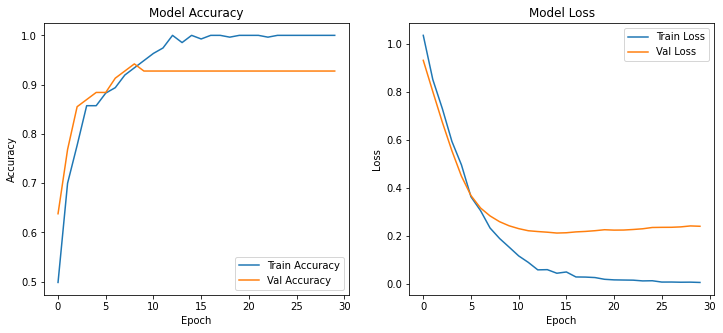

In [18]:
# Plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Trying PyTorch

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

df = pd.read_csv('coaster_db_clean.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,year_introduced,latitude,...,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft
0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,Unknown,LaMarcus Adna Thompson,1884,40.5740,...,0,2.9,600.0,48.0,8540000.0,9.1,30.0,60.0,1600,43.0
1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,Unknown,Unknown,a single car. Riders are arranged 1 across in ...,Lina Beecher,1895,40.5780,...,1,12.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
2,Loop the Loop (Coney Island),Other,Removed,Edwin Prescott,Unknown,Unknown,a single car. Riders are arranged 2 across in ...,Edward A. Green,1901,40.5745,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
3,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,Unknown,Unknown,Unknown,Edward A. Green,1901,39.3538,...,1,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0
4,Cannon Coaster,Coney Island,Removed,George Francis Meyer,Unknown,Unknown,Unknown,Unknown,1902,40.5750,...,0,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              1028 non-null   object 
 1   Location                  1028 non-null   object 
 2   Status                    1028 non-null   object 
 3   Manufacturer              1028 non-null   object 
 4   Model                     1028 non-null   object 
 5   Lift/launch system        1028 non-null   object 
 6   Trains                    1028 non-null   object 
 7   Designer                  1028 non-null   object 
 8   year_introduced           1028 non-null   int64  
 9   latitude                  1028 non-null   float64
 10  longitude                 1028 non-null   float64
 11  track_type                1028 non-null   object 
 12  opening_date_clean        1028 non-null   object 
 13  speed_mph                 1028 non-null   float64
 14  height_f

In [21]:
X = df.drop(columns=['track_type'])
y = df['track_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# numeric and categorical feature lists
numeric_features = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']
categorical_features = [col for col in X.columns if col not in numeric_features]

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# fit on training, transform both train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# make sure Keras sees float32
X_train_prep = X_train_prep.astype("float32")
X_test_prep = X_test_prep.astype("float32")

# Convert sparse matrices to dense arrays
if hasattr(X_train_prep, "toarray"):
    X_train_prep = X_train_prep.toarray()
if hasattr(X_test_prep, "toarray"):
    X_test_prep = X_test_prep.toarray()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_prep, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_prep, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)

# Define the neural network architecture 
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No softmax here — CrossEntropyLoss applies it internally
        return x

# Instantiate the model
input_dim = X_train_prep.shape[1]
output_dim = 3  # 3 classes
model = NeuralNet(input_dim, output_dim)

# Define loss function and optimizer 
criterion = nn.CrossEntropyLoss()  # same as sparse_categorical_crossentropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

print(f"\nTest Accuracy: {acc:.4f}")

Epoch [1/30] - Loss: 0.9484, Accuracy: 0.7348
Epoch [2/30] - Loss: 0.5310, Accuracy: 0.7920
Epoch [3/30] - Loss: 0.3207, Accuracy: 0.8929
Epoch [4/30] - Loss: 0.1810, Accuracy: 0.9465
Epoch [5/30] - Loss: 0.1088, Accuracy: 0.9623
Epoch [6/30] - Loss: 0.0775, Accuracy: 0.9623
Epoch [7/30] - Loss: 0.0638, Accuracy: 0.9647
Epoch [8/30] - Loss: 0.0440, Accuracy: 0.9854
Epoch [9/30] - Loss: 0.0278, Accuracy: 0.9951
Epoch [10/30] - Loss: 0.0178, Accuracy: 1.0000
Epoch [11/30] - Loss: 0.0085, Accuracy: 1.0000
Epoch [12/30] - Loss: 0.0059, Accuracy: 1.0000
Epoch [13/30] - Loss: 0.0033, Accuracy: 1.0000
Epoch [14/30] - Loss: 0.0026, Accuracy: 1.0000
Epoch [15/30] - Loss: 0.0028, Accuracy: 1.0000
Epoch [16/30] - Loss: 0.0014, Accuracy: 1.0000
Epoch [17/30] - Loss: 0.0020, Accuracy: 1.0000
Epoch [18/30] - Loss: 0.0010, Accuracy: 1.0000
Epoch [19/30] - Loss: 0.0020, Accuracy: 1.0000
Epoch [20/30] - Loss: 0.0008, Accuracy: 1.0000
Epoch [21/30] - Loss: 0.0008, Accuracy: 1.0000
Epoch [22/30] - Loss: 

Test Accuracy: 0.9612

Classification Report:
              precision    recall  f1-score   support

       Other       0.55      0.86      0.67         7
       Steel       0.98      0.98      0.98       163
        Wood       1.00      0.89      0.94        36

    accuracy                           0.96       206
   macro avg       0.84      0.91      0.86       206
weighted avg       0.97      0.96      0.96       206



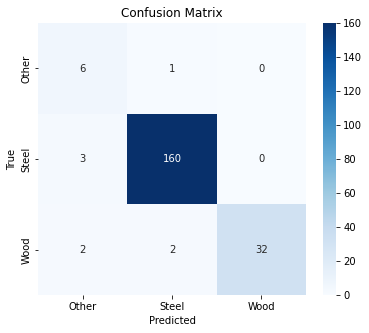

In [22]:
# Ensure model is in eval mode (turns off dropout, etc.)
model.eval()

# Move data to the same device as the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Get predictions
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_prep, dtype=torch.float32).to(device)
    outputs = model(X_test_tensor)

# Convert logits to predicted class labels
y_pred_probs = torch.softmax(outputs, dim=1).cpu().numpy()
y_pred = np.argmax(y_pred_probs, axis=1)

# Ground truth (convert to numpy if it’s a tensor)
y_true = y_test_enc if isinstance(y_test_enc, np.ndarray) else y_test_enc.cpu().numpy()

# Accuracy
acc = (y_pred == y_true).mean()
print(f"Test Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()